# Video Classification Model

# Project Overview

## Context
For Canadians, falls are a leading cause of injury-related hospitalizations for those aged 65 or older. Not only do they lead to negative physical consequences such as broken or fractured bones, they also pose a risk to the individual's mental health. In fact, statistics indicate that 20 to 30 percent of seniors fall each year, where each fall harms not only the injured individual, but affects family, friends, care providers, and the health care system. 

This project focuses on detecting falls from a video dataset with a high degree of accuracy. Further extensions to this project are to detect discrepancies in more complex models, such as identifying movement disorders and gait symptoms.

## Work Done 
A ConvLSTM2D was constructed using Keras to analyze video data and train a classification model. The two types of videos are labelled: 'fall' or 'adl' (activities of daily living). The video dataset was split into training, validation, and test sets. A final test accuracy of 90.71% was achieved. 

## References
**The dataset used for this model comes from:** 

Bogdan Kwolek, Michal Kepski, Human fall detection on embedded platform using depth maps and wireless accelerometer, Computer Methods and Programs in Biomedicine, Volume 117, Issue 3, December 2014, Pages 489-501, ISSN 0169-2607 [Link](http://home.agh.edu.pl/~bkw/research/pdf/2014/KwolekKepski_CMBP2014.pdf)

## Code Base

In [2]:
## Import the required libraries
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import datetime as dt
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
from numpy.random import seed

import cv2
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob

## Define a class
class video_classification:
  def __init__(self, data_loc, output_loc, class_list):
    """ 
    The video data has already been split into frames. 
    File directory looks like:
        - data_loc
          - Video1 Frames
          - Video2 Frames
          - Video3 Frames
    """
    self.seed_constant = 15
    self.data_loc = data_loc # The location storing all the different folders containing each video's frames
    self.output_loc = output_loc
    self.class_list = class_list
    self.model_output_size = len(class_list)
    self.x_train, self.x_test, self.y_train, self.y_test = None, None, None, None

  def preprocess_each_frame(self, frame, image_height, image_width):
    """ Applied to preprocess each and every frame. """
    # Resize to avoid doing unnecessary computation
    resized_frame = cv2.resize(frame, (image_height, image_width))
    # Have each pixel value between 0 and 1
    normalized_frame = resized_frame / 255
    return normalized_frame

  def generate_one_video(self, video_folder_path, num_frames, image_height, image_width):
    """ Loop through all frames for one video and append into one list. We're not gonna take all the frames. We taking 10 frames from within the video. 
        Assume video_folder_path doesn't end with a / but begins with a /
    """
    # Obtain the indexing to reference the frame within the folder.
    total_num_frames = len(os.listdir(video_folder_path))
    frame_interval = total_num_frames // num_frames
    frame_index = [frame_interval*i for i in range(1, num_frames, 1)]
    #for i in range(frame_interval, total_num_frames, frame_interval):
      #frame_index.append(i)
    frame_index.append(total_num_frames - 8)

    # Pull images one at a time, call preprocess on each, then append to a list
    filenames = glob.glob(video_folder_path + '/*.png')
    filenames.sort()

    images = [self.preprocess_each_frame(cv2.imread(filenames[i]), image_height, image_width) for i in frame_index]
    # Convert to all numpy?
    np_images = np.array(images)
    #print(np_images.shape)
    return np_images

  def generate_dataset(self, num_frames, image_height, image_width):
    """ Generate the dataset for all videos. Calls generate_one_video. """
    # Initialize lists to store everything
    features = []
    labels = []

    for class_index, class_name in enumerate(self.class_list):
      print("Currently Extracting Data from Class: {}".format(class_name))
      video_names = glob.glob(data_loc + "/{}*".format(class_name))
      video_names.sort()
      for video_folder_path in video_names:
        frames = self.generate_one_video(video_folder_path, num_frames, image_height, image_width)
        features.append(frames)
        labels.append(class_index)
    
    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels

  def generate_traintestsplit(self, num_frames, image_height, image_width):
    """ Main function to call for preprocessing and dataset generation work. """
    print("Performing the train/test split...")
    seed(self.seed_constant)
    tf.random.set_seed(self.seed_constant)
    features, labels = self.generate_dataset(num_frames, image_height, image_width)
    one_hot_encoded_labels = to_categorical(labels)
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = self.seed_constant)

  def evaluate_model(self, timesteps, height, width, epoch=1, batch_size=1, verbose=2, channels=3):
    """ Main code to set up the model structure and train it using Keras """
    #self.generate_traintestsplit(timesteps, height, width)
    seed(self.seed_constant)
    tf.random.set_seed(self.seed_constant)

    model = models.Sequential(
        [
        layers.Input(
            shape=(timesteps, width, height, channels)
        ),
        # The first ConvLSTM2D Layer
        layers.ConvLSTM2D(
            filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool3D(
            pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        
        # The second ConvLSTM2D Layer 
        layers.ConvLSTM2D(
            filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool3D(
            pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=16, kernel_size=(3, 3), padding="same", return_sequences=False, dropout=0.1, recurrent_dropout=0.1
        ),
        layers.MaxPool2D(
            pool_size=(2, 2), strides=(2, 2), padding="same"
        ),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(self.model_output_size, activation='softmax')
        ]
    )

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])
    model.summary()
    # Fit the Model
    early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
    # training_history = loss, accuracy, precision, recall
    training_history = model.fit(x = self.x_train, y = self.y_train, epochs = epoch, batch_size = batch_size, verbose = 2, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
    # print(training_history.history.keys())
    
    self.plot_results(training_history)
    # Evaluate the Model
    evaluation_history = model.evaluate(self.x_test, self.y_test, batch_size = batch_size, verbose = 2)

    # Saving the Model
    model_name = self.generate_name_for_saving(evaluation_history)
    #model.save(self.output_loc + model_name)

    # Visualizing
    #self.present_visuals(model)

    print("Test Accuracy is: {}".format(evaluation_history[1]*100))
    print("Test Loss is: {}".format(evaluation_history[0]))
    return evaluation_history

  def generate_name_for_saving(self, evaluation_history):
    """ To make a default naming convention for saving model configurations. """
    date_time_formatting = "%Y_%m_%d__%H_%M_%S"
    current_time = dt.datetime.now()
    str_current_time = dt.datetime.strftime(current_time, date_time_formatting)

    model_eval_loss, model_eval_accuracy = evaluation_history
    model_name = '/Model___Date_Time_{}___Loss_{}___Accuracy_{}.h5'.format(str_current_time, model_eval_loss, model_eval_accuracy)
    return model_name

  def plot_results(self, training_history):
    """ For visuals. """
    train_loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    train_accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    num_epochs = range(len(train_loss))

    plt.figure(1)
    plt.plot(num_epochs, train_loss, label = 'train_loss')
    plt.plot(num_epochs, val_loss, label = 'val_loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.figure(2)
    plt.plot(num_epochs, train_accuracy, label = 'train_accuracy')
    plt.plot(num_epochs, val_accuracy, label = 'val_accuracy')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

  def evaluate_model_average(self, timesteps, height, width, epoch=1, num_runs = 10, batch_size=1, verbose=2, channels=3):
    """ num_runs used to find the average accuracy of many runs. """
    # Load in the data 
    # Conduct the experiment multiple times to get an averaged result
    self.generate_traintestsplit(timesteps, height, width)
    scores_list = []
    for run in range(num_runs):
      print("---------- Model Run iteration: {}. ----------".format(run+1))
      ___, accuracy = self.evaluate_model(timesteps, height, width, epoch=epoch, batch_size=batch_size, verbose=verbose, channels=channels)
      accuracy = accuracy * 100.0
      print('--> #{}: Accuracy: {:.2f}'.format(run+1, accuracy))
      scores_list.append(accuracy)
    m, s = np.mean(scores_list), np.std(scores_list)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [3]:
## declaring the class list and data locations 
data_loc = '/content/drive/MyDrive/UTBIOME/ConvLSTM/Data'
output_loc = '/content/drive/MyDrive/UTBIOME/ConvLSTM/Model_Save_After'
class_list = ['adl', 'fall']

In [4]:
## To see how many GPUs are available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Model Evaluation


Performing the train/test split...
Currently Extracting Data from Class: adl
Currently Extracting Data from Class: fall
---------- Model Run iteration: 1. ----------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 88, 88, 32)     0         
_________________________________________________________________
batch_normalization_1 

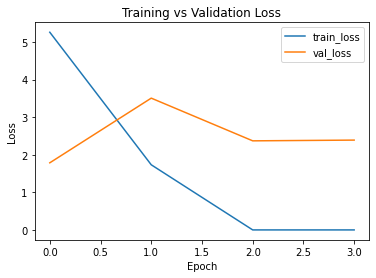

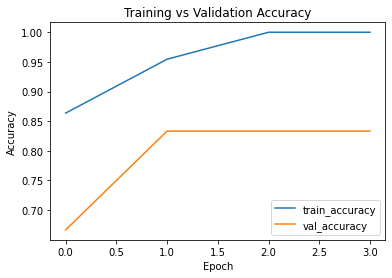

14/14 - 1s - loss: 2.6546 - accuracy: 0.7857
Test Accuracy is: 78.57142686843872
Test Loss is: 2.654601573944092
--> #1: Accuracy: 78.57
---------- Model Run iteration: 2. ----------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 4, 88, 88, 32)     0         
_________________________________________________________________
bat

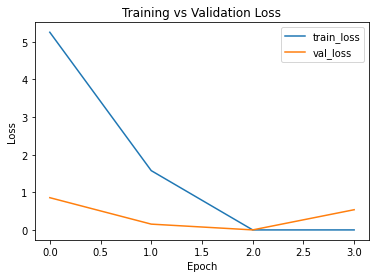

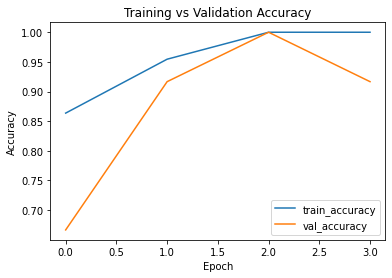

14/14 - 1s - loss: 0.0073 - accuracy: 1.0000
Test Accuracy is: 100.0
Test Loss is: 0.007264671381562948
--> #2: Accuracy: 100.00
---------- Model Run iteration: 3. ----------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_6 (ConvLSTM2D)  (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 4, 88, 88, 32)     0         
_________________________________________________________________
batch_norma

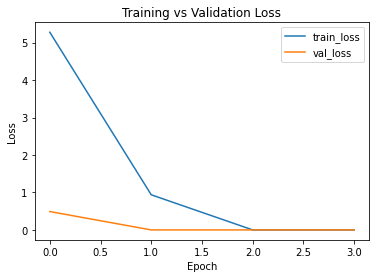

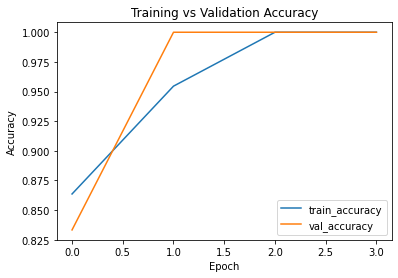

14/14 - 1s - loss: 2.4311e-04 - accuracy: 1.0000
Test Accuracy is: 100.0
Test Loss is: 0.00024311334709636867
--> #3: Accuracy: 100.00
---------- Model Run iteration: 4. ----------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_9 (ConvLSTM2D)  (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 88, 88, 32)     0         
_________________________________________________________________
batch

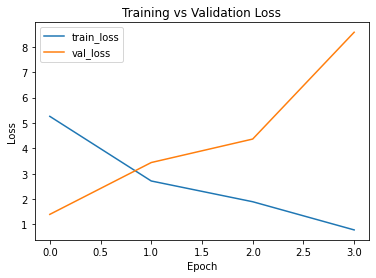

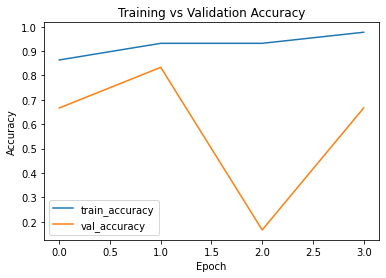

14/14 - 1s - loss: 16.1586 - accuracy: 0.4286
Test Accuracy is: 42.85714328289032
Test Loss is: 16.15860366821289
--> #4: Accuracy: 42.86
---------- Model Run iteration: 5. ----------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_12 (ConvLSTM2D) (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 4, 88, 88, 32)     0         
_________________________________________________________________
ba

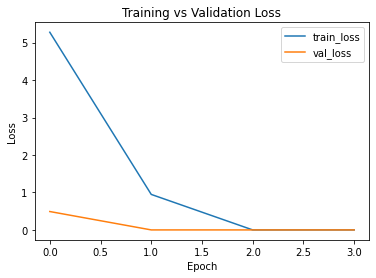

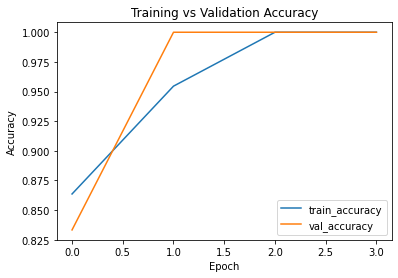

14/14 - 1s - loss: 2.1829e-04 - accuracy: 1.0000
Test Accuracy is: 100.0
Test Loss is: 0.00021828744502272457
--> #5: Accuracy: 100.00
---------- Model Run iteration: 6. ----------
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_15 (ConvLSTM2D) (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D) (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 4, 88, 88, 32)     0         
_________________________________________________________________
batch

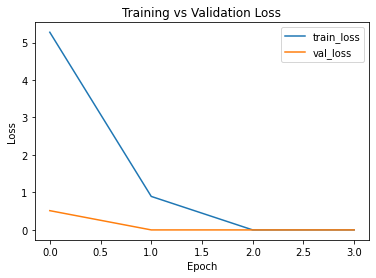

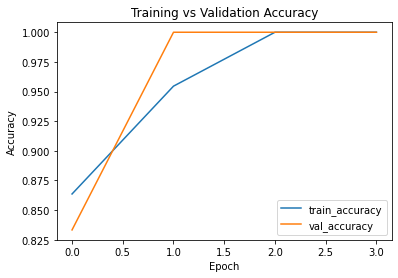

14/14 - 1s - loss: 1.0336e-04 - accuracy: 1.0000
Test Accuracy is: 100.0
Test Loss is: 0.00010335627302993089
--> #6: Accuracy: 100.00
---------- Model Run iteration: 7. ----------
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_18 (ConvLSTM2D) (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D) (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 4, 88, 88, 32)     0         
_________________________________________________________________
batch

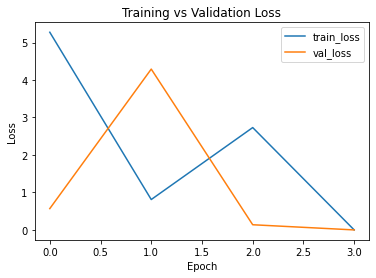

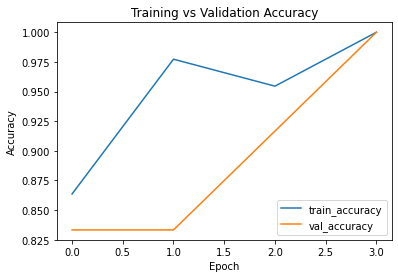

14/14 - 1s - loss: 2.1543e-06 - accuracy: 1.0000
Test Accuracy is: 100.0
Test Loss is: 2.1542514332395513e-06
--> #7: Accuracy: 100.00
---------- Model Run iteration: 8. ----------
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_21 (ConvLSTM2D) (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_22 (ConvLSTM2D) (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 4, 88, 88, 32)     0         
_________________________________________________________________
batch

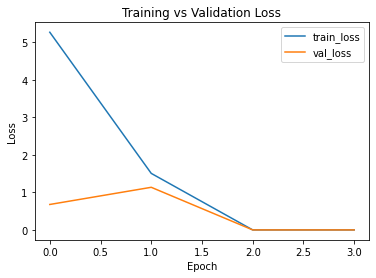

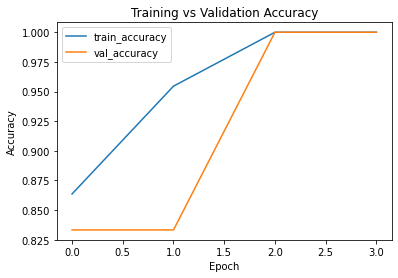

14/14 - 1s - loss: 0.1463 - accuracy: 0.9286
Test Accuracy is: 92.85714030265808
Test Loss is: 0.14630649983882904
--> #8: Accuracy: 92.86
---------- Model Run iteration: 9. ----------
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_24 (ConvLSTM2D) (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_25 (ConvLSTM2D) (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 4, 88, 88, 32)     0         
_________________________________________________________________
b

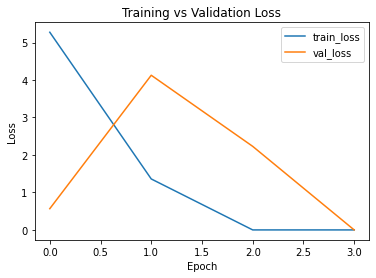

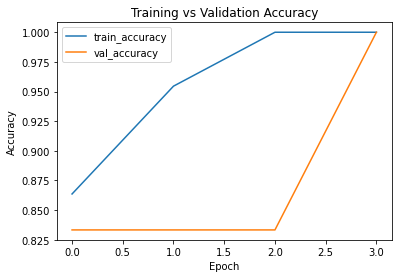

14/14 - 1s - loss: 1.1559 - accuracy: 0.9286
Test Accuracy is: 92.85714030265808
Test Loss is: 1.1558738946914673
--> #9: Accuracy: 92.86
---------- Model Run iteration: 10. ----------
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_27 (ConvLSTM2D) (None, 4, 350, 350, 64)   154624    
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 4, 175, 175, 64)   0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 4, 175, 175, 64)   256       
_________________________________________________________________
conv_lst_m2d_28 (ConvLSTM2D) (None, 4, 175, 175, 32)   110720    
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 4, 88, 88, 32)     0         
_________________________________________________________________
b

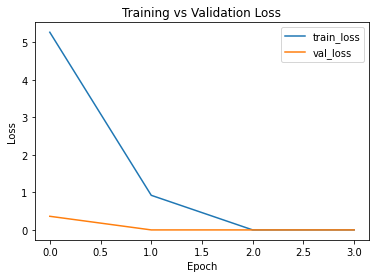

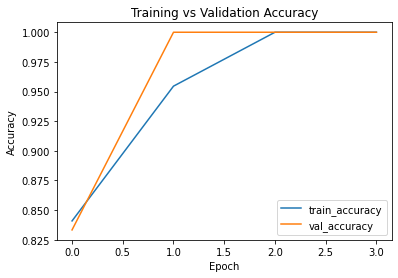

14/14 - 1s - loss: 9.8351e-04 - accuracy: 1.0000
Test Accuracy is: 100.0
Test Loss is: 0.0009835119126364589
--> #10: Accuracy: 100.00
Accuracy: 90.714% (+/-17.217)


In [5]:
## Initializing the class and evaluating the model 
model_aaa = video_classification(data_loc, output_loc, class_list)
acc = model_aaa.evaluate_model_average(4,350,350,4)